In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import os
import tarfile
from collections import OrderedDict
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import random
import argparse # Needed to load the checkpoint

# Scikit-learn (for FINAL evaluation)
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns



/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set CUDA to run synchronously for better error messages
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: True


In [3]:
# --- 1. Define Paths ---
DATASET_PATH = "." 
TRAIN_LIST_FILE = os.path.join(DATASET_PATH, "list/train.txt")
TEST_LIST_FILE = os.path.join(DATASET_PATH, "list/test.txt")
TEST_TRUTH_FILE = os.path.join(DATASET_PATH, "list/groundtruth.txt")
WITH_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_with_pairs.txt")
WITHOUT_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_without_pairs.txt")
TRAIN_IMG_DIR = DATASET_PATH
TEST_IMG_DIR = DATASET_PATH

# Path to save our best models
BEST_BACKBONE_PATH = "triplet_backbone_best_4.pth" # From Triplet Loss training
BEST_CLASSIFIER_PATH = "triplet_classifier_best_4.pth" # From Classifier training

# --- 2. Define Hyperparameters ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 100
VAL_SPLIT = 0.2 
BATCH_SIZE = 16 # Triplet loss uses more memory, so a smaller batch is safer
LEARNING_RATE_BACKBONE = 1e-5 # Very small LR for fine-tuning the backbone
LEARNING_RATE_HEAD = 1e-4 # Standard LR for training the new head
NUM_EPOCHS_BACKBONE = 20 # Epochs to train the backbone
NUM_EPOCHS_HEAD = 25 # Epochs to train the head
MARGIN = 0.2 # Triplet loss margin

print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
print("Building label map...")
train_labels_df = pd.read_csv(TRAIN_LIST_FILE, sep=' ', header=None)[1]
test_labels_df = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None)[1]
all_unique_species_ids = sorted(pd.concat([train_labels_df, test_labels_df]).unique())
label_map = {species_id: i for i, species_id in enumerate(all_unique_species_ids)}
num_mapped_classes = len(label_map)
print(f"Label map created. Total unique classes found: {num_mapped_classes}")

Building label map...
Label map created. Total unique classes found: 100


In [5]:
# --- 1. Define Augmentations ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- 2. Triplet TRAINING Dataset (Strategy 2: Positive = H or F) ---
# This dataset is for the 4,744 images in 'train.txt'
class TripletPlantDataset(Dataset):
    def __init__(self, txt_file, img_dir, label_map, transform):
        self.img_data = pd.read_csv(txt_file, sep=' ', header=None)
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        
        print("Creating class-to-image map (Training)...")
        self.class_to_images_map = {i: [] for i in range(NUM_CLASSES)}
        self.image_paths = [] # List of (path, label_index)
        
        for _, row in self.img_data.iterrows():
            img_path = row[0]
            species_id = int(row[1])
            if species_id in self.label_map:
                label_index = self.label_map[species_id]
                self.class_to_images_map[label_index].append(img_path)
                self.image_paths.append((img_path, label_index))
        
        self.all_labels = list(self.class_to_images_map.keys())
        print("Training map created.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        anchor_path, anchor_label = self.image_paths[index]
        anchor_img = Image.open(os.path.join(self.img_dir, anchor_path)).convert('RGB')
        
        positive_list = self.class_to_images_map[anchor_label]
        positive_path = anchor_path
        if len(positive_list) > 1:
            while positive_path == anchor_path:
                positive_path = random.choice(positive_list)
        positive_img = Image.open(os.path.join(self.img_dir, positive_path)).convert('RGB')

        negative_label = random.choice([label for label in self.all_labels if label != anchor_label])
        negative_path = random.choice(self.class_to_images_map[negative_label])
        negative_img = Image.open(os.path.join(self.img_dir, negative_path)).convert('RGB')
        
        if self.transform:
            anchor_img, positive_img, negative_img = [self.transform(img) for img in (anchor_img, positive_img, negative_img)]
            
        return anchor_img, positive_img, negative_img, anchor_label

# --- 3. Triplet VALIDATION Dataset (for Test Set) ---
# This dataset is for the 207 images in 'test.txt'
class TripletTestDataset(Dataset):
    def __init__(self, test_txt_file, truth_txt_file, img_dir, label_map, transform, train_class_map):
        self.test_img_data = pd.read_csv(test_txt_file, sep=' ', header=None)
        self.test_labels_data = pd.read_csv(truth_txt_file, sep=' ', header=None)
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        self.train_class_map = train_class_map # Map from training set
        
        print("Creating class-to-image map (Validation)...")
        self.class_to_images_map = {i: [] for i in range(NUM_CLASSES)}
        self.image_paths = [] # List of (path, label_index)
        
        for i, row in self.test_img_data.iterrows():
            img_path = row[0]
            species_id = int(self.test_labels_data.iloc[i, 1])
            if species_id in self.label_map:
                label_index = self.label_map[species_id]
                self.class_to_images_map[label_index].append(img_path)
                self.image_paths.append((img_path, label_index))
        
        self.all_labels = list(self.class_to_images_map.keys())
        print("Validation map created.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # 1. Get Anchor (from test set)
        anchor_path, anchor_label = self.image_paths[index]
        anchor_img = Image.open(os.path.join(self.img_dir, anchor_path)).convert('RGB')
        
        # 2. Get Positive (from test set)
        positive_list = self.class_to_images_map[anchor_label]
        positive_path = anchor_path
        if len(positive_list) > 1:
            while positive_path == anchor_path:
                positive_path = random.choice(positive_list)
        positive_img = Image.open(os.path.join(self.img_dir, positive_path)).convert('RGB')

        # 3. Get Negative (from EITHER test set or train set)
        negative_label = random.choice([label for label in self.all_labels if label != anchor_label])
        
        # We can pick a negative from the test set...
        if len(self.class_to_images_map[negative_label]) > 0:
             negative_path = random.choice(self.class_to_images_map[negative_label])
        else:
             # ...or from the training set if this class isn't in the test set
             negative_path = random.choice(self.train_class_map[negative_label])
        
        negative_img = Image.open(os.path.join(self.img_dir, negative_path)).convert('RGB')
        
        if self.transform:
            anchor_img, positive_img, negative_img = [self.transform(img) for img in (anchor_img, positive_img, negative_img)]
            
        return anchor_img, positive_img, negative_img, anchor_label

print("TripletDataset and TripletTestDataset classes and transforms defined.")

TripletDataset and TripletTestDataset classes and transforms defined.


In [6]:
# --- 1. Create Datasets (NO SPLIT) ---
train_dataset_triplet = TripletPlantDataset(txt_file=TRAIN_LIST_FILE,
                                            img_dir=TRAIN_IMG_DIR,
                                            label_map=label_map,
                                            transform=train_transform)

val_dataset_triplet = TripletTestDataset(test_txt_file=TEST_LIST_FILE,
                                         truth_txt_file=TEST_TRUTH_FILE,
                                         img_dir=TEST_IMG_DIR,
                                         label_map=label_map,
                                         transform=val_test_transform,
                                         train_class_map=train_dataset_triplet.class_to_images_map) # Pass train map

print(f"Training data: {len(train_dataset_triplet)} samples")
print(f"Validation data: {len(val_dataset_triplet)} samples")

# --- 2. Create DataLoaders ---
train_loader_triplet = DataLoader(train_dataset_triplet, batch_size=BATCH_SIZE, shuffle=True)
val_loader_triplet = DataLoader(val_dataset_triplet, batch_size=BATCH_SIZE, shuffle=False)

print(f"Triplet DataLoaders created (Batch size: {BATCH_SIZE}).")
print("Setup for Stage 1 (Triplet Training) complete.")

Creating class-to-image map (Training)...
Training map created.
Creating class-to-image map (Validation)...
Validation map created.
Training data: 4744 samples
Validation data: 207 samples
Triplet DataLoaders created (Batch size: 16).
Setup for Stage 1 (Triplet Training) complete.


In [7]:
import argparse
print("Downloading model files...")
model_dir = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
WEIGHTS_FILE = os.path.join(model_dir, 'model_best.pth.tar')
print(f"Weights file path: {WEIGHTS_FILE}")

# --- 1. Load the Model Architecture ---
print("Loading DINOv2 ViT-Base (vitb14_reg) architecture...")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
print("Architecture loaded.")

# --- 2. Load Your Kaggle Checkpoint ---
print(f"Loading weights from checkpoint: {WEIGHTS_FILE}")
torch.serialization.add_safe_globals([argparse.Namespace]) 
checkpoint = torch.load(WEIGHTS_FILE, map_location='cpu', weights_only=True)

# --- 3. Extract and Clean the 'state_dict' ---
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    raise KeyError("Checkpoint does not contain 'state_dict' key.")
    
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')
    if name == 'reg_token': name = 'register_tokens'
    if 'head.' in name: continue 
    if name == 'pos_embed':
        model_pos_embed = model.state_dict()['pos_embed']
        if v.shape != model_pos_embed.shape:
            zeros_to_add = torch.zeros(1, 1, v.shape[2])
            v = torch.cat((v, zeros_to_add), dim=1)
    new_state_dict[name] = v

# --- 4. Load Cleaned Weights ---
model.load_state_dict(new_state_dict, strict=False)
print("Successfully loaded Kaggle weights.")

# --- 5. SET MODEL AS FEATURE EXTRACTOR ---
model.head = nn.Identity()
print("Replaced model.head with nn.Identity().")

# --- 6. FREEZE THE ENTIRE MODEL (NEW) ---
print("Freezing all model parameters...")
for param in model.parameters():
    param.requires_grad = False

# --- 7. UNFREEZE Only the Last 2 Layers (NEW) ---
NUM_LAYERS_TO_UNFREEZE = 2 
print(f"Unfreezing the last {NUM_LAYERS_TO_UNFREEZE} transformer blocks (Blocks 10 & 11)...")

for i in range(NUM_LAYERS_TO_UNFREEZE):
    block_to_unfreeze = model.blocks[-(i+1)] # Get blocks from the end ([-1], [-2])
    for param in block_to_unfreeze.parameters():
        param.requires_grad = True # This layer is now trainable

# --- 8. Unfreeze the Final Normalization Layer (NEW) ---
print("Unfreezing the final norm layer...")
for param in model.norm.parameters():
    param.requires_grad = True

# --- 9. Move to GPU ---
model = model.to(DEVICE)
print(f"Model moved to {DEVICE}.")

Weights file path: /home/wongxuanyong/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3/model_best.pth.tar
Loading DINOv2 ViT-Base (vitb14_reg) architecture...


Using cache found in /home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main
/home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Architecture loaded.
Loading weights from checkpoint: /home/wongxuanyong/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3/model_best.pth.tar
Successfully loaded Kaggle weights.
Replaced model.head with nn.Identity().
Freezing all model parameters...
Unfreezing the last 2 transformer blocks (Blocks 10 & 11)...
Unfreezing the final norm layer...
Model moved to cuda.


In [8]:
import torch.nn.functional as F

# --- 1. Define Loss Function and Optimizer ---
loss_fn = nn.TripletMarginLoss(margin=MARGIN)

print("Creating optimizer for unfrozen parameters...")
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(trainable_parameters, lr=LEARNING_RATE_BACKBONE) 

# --- 2. Training Loop ---
best_val_loss = float('inf') 
history_train_loss = []
history_val_loss = []
history_train_acc = [] # <-- NEW
history_val_acc = []   # <-- NEW

print("--- STAGE 1: Fine-Tuning PARTIAL Backbone with Triplet Loss ---")

for epoch in range(NUM_EPOCHS_BACKBONE):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS_BACKBONE} ---")
    
    # --- Training Phase ---
    model.train() 
    train_loss = 0.0
    train_correct = 0 # <-- NEW: For Triplet Accuracy
    
    for anchor, positive, negative, _ in tqdm(train_loader_triplet, desc="Training"):
        anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
        
        emb_anchor, emb_positive, emb_negative = model(anchor), model(positive), model(negative)
        loss = loss_fn(emb_anchor, emb_positive, emb_negative)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Calculate Triplet Accuracy
        dist_pos = F.pairwise_distance(emb_anchor, emb_positive)
        dist_neg = F.pairwise_distance(emb_anchor, emb_negative)
        train_correct += torch.sum(dist_pos < dist_neg).item()
            
    train_loss = train_loss / len(train_loader_triplet)
    train_acc = train_correct / len(train_dataset_triplet) # <-- NEW
    print(f"Triplet Training Loss: {train_loss:.4f} | Triplet Training Acc: {train_acc*100:.2f}%") # <-- MODIFIED PRINT

    # Validation Phase
    model.eval() 
    val_loss = 0.0
    val_correct = 0 
    
    with torch.no_grad():
        for anchor, positive, negative, _ in tqdm(val_loader_triplet, desc="Validating"):
            anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
            emb_anchor, emb_positive, emb_negative = model(anchor), model(positive), model(negative)
            loss = loss_fn(emb_anchor, emb_positive, emb_negative)
            val_loss += loss.item()

            # Calculate Triplet Accuracy ---
            dist_pos = F.pairwise_distance(emb_anchor, emb_positive)
            dist_neg = F.pairwise_distance(emb_anchor, emb_negative)
            val_correct += torch.sum(dist_pos < dist_neg).item()

    val_loss = val_loss / len(val_loader_triplet)
    val_acc = val_correct / len(val_dataset_triplet)
    print(f"Triplet Validation Loss: {val_loss:.4f} | Triplet Validation Acc: {val_acc*100:.2f}%") # <-- MODIFIED PRINT
    
    history_train_loss.append(train_loss)
    history_val_loss.append(val_loss)
    history_train_acc.append(train_acc)
    history_val_acc.append(val_acc)
    
    # --- Save the Best Backbone Model ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_BACKBONE_PATH)
        print(f"*** New best BACKBONE saved! Validation Loss: {best_val_loss:.4f} ***")

print("\n--- Backbone Fine-Tuning Complete ---")

Creating optimizer for unfrozen parameters...
--- STAGE 1: Fine-Tuning PARTIAL Backbone with Triplet Loss ---

--- Epoch 1/20 ---


Training: 100%|██████████| 297/297 [05:59<00:00,  1.21s/it]


Triplet Training Loss: 0.3297 | Triplet Training Acc: 77.99%


Validating: 100%|██████████| 13/13 [00:14<00:00,  1.15s/it]


Triplet Validation Loss: 0.1312 | Triplet Validation Acc: 89.86%
*** New best BACKBONE saved! Validation Loss: 0.1312 ***

--- Epoch 2/20 ---


Training: 100%|██████████| 297/297 [06:09<00:00,  1.24s/it]


Triplet Training Loss: 0.1684 | Triplet Training Acc: 81.43%


Validating: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it]


Triplet Validation Loss: 0.0664 | Triplet Validation Acc: 91.79%
*** New best BACKBONE saved! Validation Loss: 0.0664 ***

--- Epoch 3/20 ---


Training: 100%|██████████| 297/297 [06:07<00:00,  1.24s/it]


Triplet Training Loss: 0.1244 | Triplet Training Acc: 84.27%


Validating: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Triplet Validation Loss: 0.0634 | Triplet Validation Acc: 91.30%
*** New best BACKBONE saved! Validation Loss: 0.0634 ***

--- Epoch 4/20 ---


Training: 100%|██████████| 297/297 [06:22<00:00,  1.29s/it]


Triplet Training Loss: 0.0980 | Triplet Training Acc: 85.27%


Validating: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Triplet Validation Loss: 0.0598 | Triplet Validation Acc: 90.82%
*** New best BACKBONE saved! Validation Loss: 0.0598 ***

--- Epoch 5/20 ---


Training: 100%|██████████| 297/297 [06:13<00:00,  1.26s/it]


Triplet Training Loss: 0.0853 | Triplet Training Acc: 85.67%


Validating: 100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


Triplet Validation Loss: 0.0418 | Triplet Validation Acc: 91.30%
*** New best BACKBONE saved! Validation Loss: 0.0418 ***

--- Epoch 6/20 ---


Training: 100%|██████████| 297/297 [06:07<00:00,  1.24s/it]


Triplet Training Loss: 0.0804 | Triplet Training Acc: 85.08%


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.16s/it]


Triplet Validation Loss: 0.0579 | Triplet Validation Acc: 89.37%

--- Epoch 7/20 ---


Training: 100%|██████████| 297/297 [06:22<00:00,  1.29s/it]


Triplet Training Loss: 0.0741 | Triplet Training Acc: 85.88%


Validating: 100%|██████████| 13/13 [00:14<00:00,  1.14s/it]


Triplet Validation Loss: 0.0373 | Triplet Validation Acc: 90.82%
*** New best BACKBONE saved! Validation Loss: 0.0373 ***

--- Epoch 8/20 ---


Training: 100%|██████████| 297/297 [06:20<00:00,  1.28s/it]


Triplet Training Loss: 0.0644 | Triplet Training Acc: 87.50%


Validating: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it]


Triplet Validation Loss: 0.0284 | Triplet Validation Acc: 95.17%
*** New best BACKBONE saved! Validation Loss: 0.0284 ***

--- Epoch 9/20 ---


Training: 100%|██████████| 297/297 [06:21<00:00,  1.29s/it]


Triplet Training Loss: 0.0631 | Triplet Training Acc: 87.44%


Validating: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it]


Triplet Validation Loss: 0.0349 | Triplet Validation Acc: 93.24%

--- Epoch 10/20 ---


Training: 100%|██████████| 297/297 [06:16<00:00,  1.27s/it]


Triplet Training Loss: 0.0551 | Triplet Training Acc: 88.87%


Validating: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Triplet Validation Loss: 0.0228 | Triplet Validation Acc: 97.10%
*** New best BACKBONE saved! Validation Loss: 0.0228 ***

--- Epoch 11/20 ---


Training: 100%|██████████| 297/297 [06:17<00:00,  1.27s/it]


Triplet Training Loss: 0.0559 | Triplet Training Acc: 88.45%


Validating: 100%|██████████| 13/13 [00:14<00:00,  1.15s/it]


Triplet Validation Loss: 0.0416 | Triplet Validation Acc: 92.75%

--- Epoch 12/20 ---


Training: 100%|██████████| 297/297 [06:18<00:00,  1.28s/it]


Triplet Training Loss: 0.0524 | Triplet Training Acc: 89.29%


Validating: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Triplet Validation Loss: 0.0317 | Triplet Validation Acc: 92.75%

--- Epoch 13/20 ---


Training: 100%|██████████| 297/297 [06:19<00:00,  1.28s/it]


Triplet Training Loss: 0.0518 | Triplet Training Acc: 89.95%


Validating: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Triplet Validation Loss: 0.0317 | Triplet Validation Acc: 93.72%

--- Epoch 14/20 ---


Training: 100%|██████████| 297/297 [06:21<00:00,  1.29s/it]


Triplet Training Loss: 0.0493 | Triplet Training Acc: 89.84%


Validating: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Triplet Validation Loss: 0.0260 | Triplet Validation Acc: 95.17%

--- Epoch 15/20 ---


Training: 100%|██████████| 297/297 [06:38<00:00,  1.34s/it]


Triplet Training Loss: 0.0471 | Triplet Training Acc: 90.60%


Validating: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Triplet Validation Loss: 0.0265 | Triplet Validation Acc: 94.69%

--- Epoch 16/20 ---


Training: 100%|██████████| 297/297 [06:58<00:00,  1.41s/it]


Triplet Training Loss: 0.0453 | Triplet Training Acc: 91.08%


Validating: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Triplet Validation Loss: 0.0266 | Triplet Validation Acc: 95.17%

--- Epoch 17/20 ---


Training: 100%|██████████| 297/297 [07:03<00:00,  1.43s/it]


Triplet Training Loss: 0.0441 | Triplet Training Acc: 90.89%


Validating: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Triplet Validation Loss: 0.0170 | Triplet Validation Acc: 97.10%
*** New best BACKBONE saved! Validation Loss: 0.0170 ***

--- Epoch 18/20 ---


Training: 100%|██████████| 297/297 [07:07<00:00,  1.44s/it]


Triplet Training Loss: 0.0418 | Triplet Training Acc: 91.25%


Validating: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Triplet Validation Loss: 0.0229 | Triplet Validation Acc: 96.62%

--- Epoch 19/20 ---


Training: 100%|██████████| 297/297 [07:13<00:00,  1.46s/it]


Triplet Training Loss: 0.0401 | Triplet Training Acc: 91.80%


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]


Triplet Validation Loss: 0.0319 | Triplet Validation Acc: 94.20%

--- Epoch 20/20 ---


Training: 100%|██████████| 297/297 [07:14<00:00,  1.46s/it]


Triplet Training Loss: 0.0391 | Triplet Training Acc: 91.86%


Validating: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]

Triplet Validation Loss: 0.0305 | Triplet Validation Acc: 93.24%

--- Backbone Fine-Tuning Complete ---


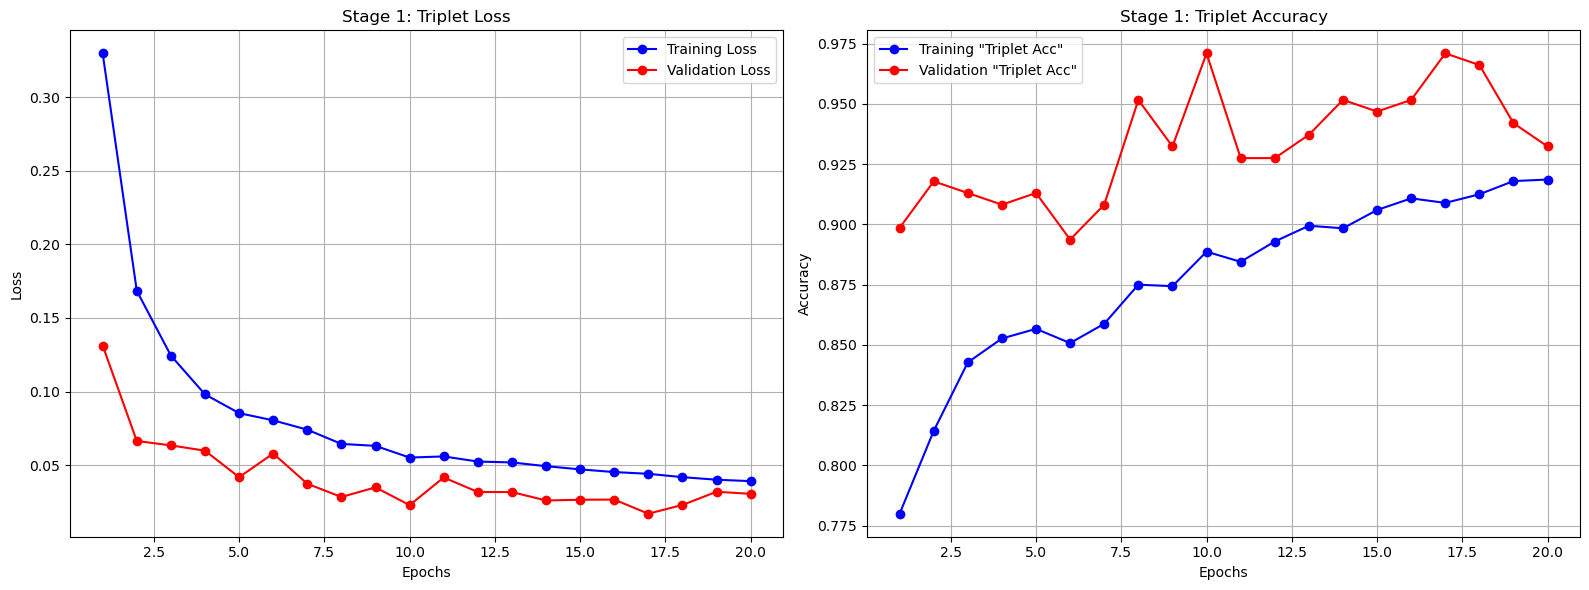

In [9]:
# Create a list of epoch numbers
epochs = range(1, len(history_train_loss) + 1)

plt.figure(figsize=(16, 6))

# Plot 1: Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, history_val_loss, 'r-o', label='Validation Loss')
plt.title('Stage 1: Triplet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training & Validation "Triplet Accuracy"
plt.subplot(1, 2, 2)
plt.plot(epochs, history_train_acc, 'b-o', label='Training "Triplet Acc"')
plt.plot(epochs, history_val_acc, 'r-o', label='Validation "Triplet Acc"')
plt.title('Stage 1: Triplet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# --- 1. Define Classification Dataset ---
# This is the dataset from your 2.ipynb, using the correct label_map
class PlantClassifierDataset(Dataset):
    def __init__(self, txt_file, img_dir, label_map, transform, is_test=False, label_file=None):
        self.is_test = is_test
        self.img_data = pd.read_csv(txt_file, sep=' ', header=None)
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        
        if label_file: # Load labels from a separate file (e.g., groundtruth.txt)
            self.labels = pd.read_csv(label_file, sep=' ', header=None)[1].values
        elif not is_test: # Load labels from the main file (e.g., train.txt)
            self.labels = self.img_data[1].values
        else: # No labels for the test set
            self.labels = None

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_name = self.img_data.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            species_id = int(self.labels[idx])
            label = self.label_map[species_id]
            return image, label

print("PlantClassifierDataset defined.")



PlantClassifierDataset defined.


In [11]:
# --- 2. Create Datasets ---
# We use the FULL training set with augmentations
train_dataset_cls = PlantClassifierDataset(txt_file=TRAIN_LIST_FILE,
                                           img_dir=TRAIN_IMG_DIR,
                                           label_map=label_map,
                                           transform=train_transform, # Use augmentations
                                           is_test=False)

# We use the TEST set as our validation set
val_dataset_cls = PlantClassifierDataset(txt_file=TEST_LIST_FILE,
                                         img_dir=TEST_IMG_DIR,
                                         label_map=label_map,
                                         transform=val_test_transform, # No augmentations
                                         is_test=False,
                                         label_file=TEST_TRUTH_FILE)

# --- ADDED: Create the Test Dataset (for final evaluation) ---
test_dataset = PlantClassifierDataset(txt_file=TEST_LIST_FILE,
                                      img_dir=TEST_IMG_DIR,
                                      label_map=label_map,
                                      transform=val_test_transform,
                                      is_test=True) # is_test=True

# --- ADDED: Calculate Class Weights ---
print("\nCalculating class weights for imbalance...")
all_train_labels = pd.read_csv(TRAIN_LIST_FILE, sep=' ', header=None)[1].map(label_map)
class_counts_series = all_train_labels.value_counts()

full_class_index = np.arange(NUM_CLASSES)
class_counts = class_counts_series.reindex(full_class_index, fill_value=0).sort_index()
counts_plus_one = torch.tensor(class_counts.values, dtype=torch.float) + 1.0
class_weights = 1.0 / counts_plus_one
class_weights = class_weights / class_weights.sum() * NUM_CLASSES
class_weights = class_weights.to(DEVICE)
print(f"Class weights tensor created with {len(class_weights)} entries.")

# --- 3. Create DataLoaders ---
train_loader_cls = DataLoader(train_dataset_cls, batch_size=BATCH_SIZE, shuffle=True)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # <-- ADDED
print(f"Created Classifier DataLoaders: {len(train_loader_cls)} train, {len(val_loader_cls)} val, {len(test_loader)} test batches.")

# --- ADDED: Load and map y_test ---
original_test_labels = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None).iloc[:, 1].values
y_test = np.array([label_map[label] for label in original_test_labels])
print(f"y_test (ground truth) labels loaded and mapped to [0-99].")


Calculating class weights for imbalance...
Class weights tensor created with 100 entries.
Created Classifier DataLoaders: 297 train, 13 val, 13 test batches.
y_test (ground truth) labels loaded and mapped to [0-99].


In [12]:
# --- 1. Load the Best Fine-Tuned Backbone ---
print("Loading best fine-tuned BACKBONE...")
classifier_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
classifier_model.head = nn.Identity() # It's a backbone

# Load the weights we saved in Cell 7
classifier_model.load_state_dict(torch.load(BEST_BACKBONE_PATH, weights_only=True))
print("Best backbone weights loaded.")

# --- 2. Freeze all parameters FIRST ---
print("Freezing all model parameters...")
for param in classifier_model.parameters():
    param.requires_grad = False

# --- 3. UNFREEZE the Last 2 Layers (NEW) ---
NUM_LAYERS_TO_UNFREEZE = 2 
print(f"Unfreezing the last {NUM_LAYERS_TO_UNFREEZE} transformer blocks (Blocks 10 & 11)...")
for i in range(NUM_LAYERS_TO_UNFREEZE):
    block_to_unfreeze = classifier_model.blocks[-(i+1)]
    for param in block_to_unfreeze.parameters():
        param.requires_grad = True # This layer is now trainable

# --- 4. Unfreeze the Final Normalization Layer (NEW) ---
print("Unfreezing the final norm layer...")
for param in classifier_model.norm.parameters():
    param.requires_grad = True

# --- 5. Add New Classifier Head ---
# The new head will have requires_grad=True by default
classifier_model.head = nn.Linear(768, NUM_CLASSES)
print(f"Added new nn.Linear(768, {NUM_CLASSES}) head.")
classifier_model = classifier_model.to(DEVICE)
print(f"Model moved to {DEVICE}.")

Loading best fine-tuned BACKBONE...


Using cache found in /home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main


Best backbone weights loaded.
Freezing all model parameters...
Unfreezing the last 2 transformer blocks (Blocks 10 & 11)...
Unfreezing the final norm layer...
Added new nn.Linear(768, 100) head.
Model moved to cuda.


In [13]:
# --- 1. Define NEW Loss and Optimizer (MODIFIED) ---
loss_fn_cls = nn.CrossEntropyLoss(weight=class_weights)

print("Creating optimizer with differential learning rates...")
# Create parameter groups
# We use the LEARNING_RATE_BACKBONE (e.g., 1e-5) for the layers we are fine-tuning
param_group_backbone = [
    {'params': classifier_model.blocks[-1].parameters(), 'lr': LEARNING_RATE_BACKBONE},
    {'params': classifier_model.blocks[-2].parameters(), 'lr': LEARNING_RATE_BACKBONE},
    {'params': classifier_model.norm.parameters(), 'lr': LEARNING_RATE_BACKBONE},
]
# We use the (larger) LEARNING_RATE_HEAD (e.g., 1e-3) for the new head
param_group_head = [
    {'params': classifier_model.head.parameters(), 'lr': LEARNING_RATE_HEAD}
]

# Combine them in the optimizer
optimizer_cls = optim.AdamW(param_group_backbone + param_group_head) 

# --- 5. Training Loop for the Head ---
best_val_acc = 0.0
history_train_loss_cls = []
history_train_acc_cls = []
history_val_loss_cls = []
history_val_acc_cls = []

print("\n--- STAGE 2: Training Classifier Head & Fine-Tuning Last 2 Layers ---")

for epoch in range(NUM_EPOCHS_HEAD):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS_HEAD} ---")
    
    classifier_model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in tqdm(train_loader_cls, desc="Training Head"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        outputs = classifier_model(images)
        loss = loss_fn_cls(outputs, labels)
        
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
        
    train_acc = train_correct.double() / len(train_dataset_cls)
    train_loss = train_loss / len(train_dataset_cls)
    print(f"Classifier Training Loss: {train_loss:.4f} | Training Acc: {train_acc*100:.2f}%")

    classifier_model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_cls, desc="Validating Head"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = classifier_model(images)
            loss = loss_fn_cls(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_acc = val_correct.double() / len(val_dataset_cls)
    val_loss = val_loss / len(val_dataset_cls)
    print(f"Classifier Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc*100:.2f}%")
    
    history_train_loss_cls.append(train_loss)
    history_train_acc_cls.append(train_acc.cpu()) 
    history_val_loss_cls.append(val_loss)
    history_val_acc_cls.append(val_acc.cpu()) 
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(classifier_model.state_dict(), BEST_CLASSIFIER_PATH)
        print(f"*** New best CLASSIFIER saved! Accuracy: {best_val_acc*100:.2f}% ***")

print("\n--- Classifier Training Complete ---")

Creating optimizer with differential learning rates...

--- STAGE 2: Training Classifier Head & Fine-Tuning Last 2 Layers ---

--- Epoch 1/25 ---


Training Head: 100%|██████████| 297/297 [02:27<00:00,  2.02it/s]


Classifier Training Loss: 3.9759 | Training Acc: 15.75%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Classifier Validation Loss: 3.1621 | Validation Acc: 37.20%
*** New best CLASSIFIER saved! Accuracy: 37.20% ***

--- Epoch 2/25 ---


Training Head: 100%|██████████| 297/297 [02:29<00:00,  1.99it/s]


Classifier Training Loss: 1.9429 | Training Acc: 58.03%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Classifier Validation Loss: 2.2554 | Validation Acc: 53.14%
*** New best CLASSIFIER saved! Accuracy: 53.14% ***

--- Epoch 3/25 ---


Training Head: 100%|██████████| 297/297 [02:29<00:00,  1.99it/s]


Classifier Training Loss: 1.3628 | Training Acc: 69.16%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Classifier Validation Loss: 1.9966 | Validation Acc: 58.45%
*** New best CLASSIFIER saved! Accuracy: 58.45% ***

--- Epoch 4/25 ---


Training Head: 100%|██████████| 297/297 [02:28<00:00,  2.00it/s]


Classifier Training Loss: 1.1067 | Training Acc: 74.30%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Classifier Validation Loss: 1.8581 | Validation Acc: 60.87%
*** New best CLASSIFIER saved! Accuracy: 60.87% ***

--- Epoch 5/25 ---


Training Head: 100%|██████████| 297/297 [02:28<00:00,  1.99it/s]


Classifier Training Loss: 0.9228 | Training Acc: 78.16%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Classifier Validation Loss: 1.7868 | Validation Acc: 63.29%
*** New best CLASSIFIER saved! Accuracy: 63.29% ***

--- Epoch 6/25 ---


Training Head: 100%|██████████| 297/297 [02:28<00:00,  1.99it/s]


Classifier Training Loss: 0.7989 | Training Acc: 81.32%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Classifier Validation Loss: 1.7578 | Validation Acc: 63.77%
*** New best CLASSIFIER saved! Accuracy: 63.77% ***

--- Epoch 7/25 ---


Training Head: 100%|██████████| 297/297 [02:28<00:00,  2.00it/s]


Classifier Training Loss: 0.7071 | Training Acc: 82.86%


Validating Head: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Classifier Validation Loss: 1.7136 | Validation Acc: 63.29%

--- Epoch 8/25 ---


Training Head: 100%|██████████| 297/297 [02:42<00:00,  1.83it/s]


Classifier Training Loss: 0.6238 | Training Acc: 84.82%


Validating Head: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Classifier Validation Loss: 1.6920 | Validation Acc: 65.70%
*** New best CLASSIFIER saved! Accuracy: 65.70% ***

--- Epoch 9/25 ---


Training Head: 100%|██████████| 297/297 [02:38<00:00,  1.87it/s]


Classifier Training Loss: 0.5620 | Training Acc: 86.40%


Validating Head: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Classifier Validation Loss: 1.6753 | Validation Acc: 65.70%

--- Epoch 10/25 ---


Training Head: 100%|██████████| 297/297 [02:34<00:00,  1.92it/s]


Classifier Training Loss: 0.5041 | Training Acc: 87.88%


Validating Head: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Classifier Validation Loss: 1.6775 | Validation Acc: 66.18%
*** New best CLASSIFIER saved! Accuracy: 66.18% ***

--- Epoch 11/25 ---


Training Head: 100%|██████████| 297/297 [02:33<00:00,  1.94it/s]


Classifier Training Loss: 0.4487 | Training Acc: 89.27%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Classifier Validation Loss: 1.6662 | Validation Acc: 67.15%
*** New best CLASSIFIER saved! Accuracy: 67.15% ***

--- Epoch 12/25 ---


Training Head: 100%|██████████| 297/297 [02:37<00:00,  1.88it/s]


Classifier Training Loss: 0.3986 | Training Acc: 90.11%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Classifier Validation Loss: 1.6645 | Validation Acc: 64.73%

--- Epoch 13/25 ---


Training Head: 100%|██████████| 297/297 [02:34<00:00,  1.92it/s]


Classifier Training Loss: 0.3685 | Training Acc: 91.23%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Classifier Validation Loss: 1.6671 | Validation Acc: 68.12%
*** New best CLASSIFIER saved! Accuracy: 68.12% ***

--- Epoch 14/25 ---


Training Head: 100%|██████████| 297/297 [02:35<00:00,  1.91it/s]


Classifier Training Loss: 0.3289 | Training Acc: 92.18%


Validating Head: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


Classifier Validation Loss: 1.6409 | Validation Acc: 68.60%
*** New best CLASSIFIER saved! Accuracy: 68.60% ***

--- Epoch 15/25 ---


Training Head: 100%|██████████| 297/297 [02:36<00:00,  1.90it/s]


Classifier Training Loss: 0.2911 | Training Acc: 93.72%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Classifier Validation Loss: 1.6560 | Validation Acc: 69.08%
*** New best CLASSIFIER saved! Accuracy: 69.08% ***

--- Epoch 16/25 ---


Training Head: 100%|██████████| 297/297 [02:31<00:00,  1.96it/s]


Classifier Training Loss: 0.2646 | Training Acc: 93.66%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Classifier Validation Loss: 1.6485 | Validation Acc: 69.57%
*** New best CLASSIFIER saved! Accuracy: 69.57% ***

--- Epoch 17/25 ---


Training Head: 100%|██████████| 297/297 [02:30<00:00,  1.97it/s]


Classifier Training Loss: 0.2316 | Training Acc: 94.48%


Validating Head: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Classifier Validation Loss: 1.6529 | Validation Acc: 70.05%
*** New best CLASSIFIER saved! Accuracy: 70.05% ***

--- Epoch 18/25 ---


Training Head: 100%|██████████| 297/297 [02:30<00:00,  1.97it/s]


Classifier Training Loss: 0.2257 | Training Acc: 94.81%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Classifier Validation Loss: 1.6601 | Validation Acc: 71.01%
*** New best CLASSIFIER saved! Accuracy: 71.01% ***

--- Epoch 19/25 ---


Training Head: 100%|██████████| 297/297 [02:30<00:00,  1.97it/s]


Classifier Training Loss: 0.2007 | Training Acc: 95.49%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Classifier Validation Loss: 1.6703 | Validation Acc: 68.60%

--- Epoch 20/25 ---


Training Head: 100%|██████████| 297/297 [02:28<00:00,  2.00it/s]


Classifier Training Loss: 0.1739 | Training Acc: 96.54%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Classifier Validation Loss: 1.6716 | Validation Acc: 71.01%

--- Epoch 21/25 ---


Training Head: 100%|██████████| 297/297 [02:27<00:00,  2.01it/s]


Classifier Training Loss: 0.1641 | Training Acc: 96.10%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Classifier Validation Loss: 1.6871 | Validation Acc: 69.08%

--- Epoch 22/25 ---


Training Head: 100%|██████████| 297/297 [02:27<00:00,  2.02it/s]


Classifier Training Loss: 0.1382 | Training Acc: 97.13%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Classifier Validation Loss: 1.7112 | Validation Acc: 69.08%

--- Epoch 23/25 ---


Training Head: 100%|██████████| 297/297 [02:26<00:00,  2.03it/s]


Classifier Training Loss: 0.1288 | Training Acc: 97.81%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Classifier Validation Loss: 1.7073 | Validation Acc: 69.08%

--- Epoch 24/25 ---


Training Head: 100%|██████████| 297/297 [02:26<00:00,  2.02it/s]


Classifier Training Loss: 0.1250 | Training Acc: 97.18%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Classifier Validation Loss: 1.7063 | Validation Acc: 69.57%

--- Epoch 25/25 ---


Training Head: 100%|██████████| 297/297 [02:26<00:00,  2.03it/s]


Classifier Training Loss: 0.1101 | Training Acc: 97.70%


Validating Head: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]

Classifier Validation Loss: 1.6899 | Validation Acc: 70.05%

--- Classifier Training Complete ---


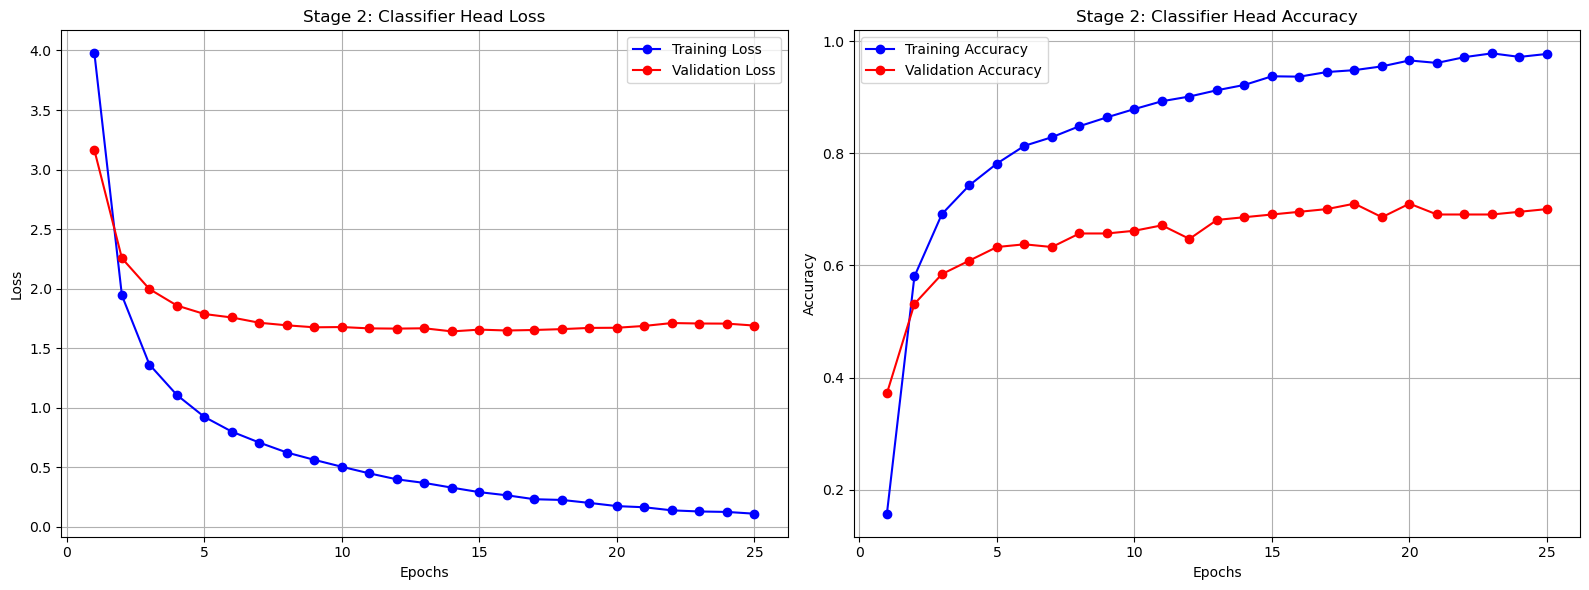

In [14]:
epochs_cls = range(1, len(history_train_loss_cls) + 1)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_cls, history_train_loss_cls, 'b-o', label='Training Loss')
plt.plot(epochs_cls, history_val_loss_cls, 'r-o', label='Validation Loss')
plt.title('Stage 2: Classifier Head Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_cls, history_train_acc_cls, 'b-o', label='Training Accuracy')
plt.plot(epochs_cls, history_val_acc_cls, 'r-o', label='Validation Accuracy')
plt.title('Stage 2: Classifier Head Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
# --- 1. Load the Best FULL Model (Backbone + Head) ---
print("Loading best fine-tuned CLASSIFIER model for final evaluation...")
# Create a new instance of the model architecture
eval_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
eval_model.head = nn.Linear(768, NUM_CLASSES)

# Load the saved classifier weights
eval_model.load_state_dict(torch.load(BEST_CLASSIFIER_PATH, weights_only=True))
eval_model = eval_model.to(DEVICE)
eval_model.eval() 
print("Best classifier model loaded.")

# --- 2. Evaluate on Test Set ---
all_predictions = []
with torch.no_grad():
    for images in tqdm(test_loader, desc="Evaluating on Test Set"):
        images = images.to(DEVICE)
        outputs = eval_model(images)
        all_predictions.append(outputs.cpu())

y_pred_probas = torch.cat(all_predictions, dim=0)
y_pred_top1 = torch.argmax(y_pred_probas, dim=1).numpy()
print("Evaluation complete.")

# --- 3. Calculate Final Metrics ---
all_class_labels = np.arange(NUM_CLASSES)
top1_acc = accuracy_score(y_test, y_pred_top1)
top5_acc = top_k_accuracy_score(y_test, y_pred_probas.numpy(), k=5, labels=all_class_labels)

print(f"\n--- New Approach (Triplet + Classifier) Results ---")
print(f"  Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"  Top-5 Accuracy: {top5_acc * 100:.2f}%")

Loading best fine-tuned CLASSIFIER model for final evaluation...


Using cache found in /home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main


Best classifier model loaded.


Evaluating on Test Set: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]

Evaluation complete.

--- New Approach (Triplet + Classifier) Results ---
  Top-1 Accuracy: 71.01%
  Top-5 Accuracy: 83.09%


Generating confusion matrix...


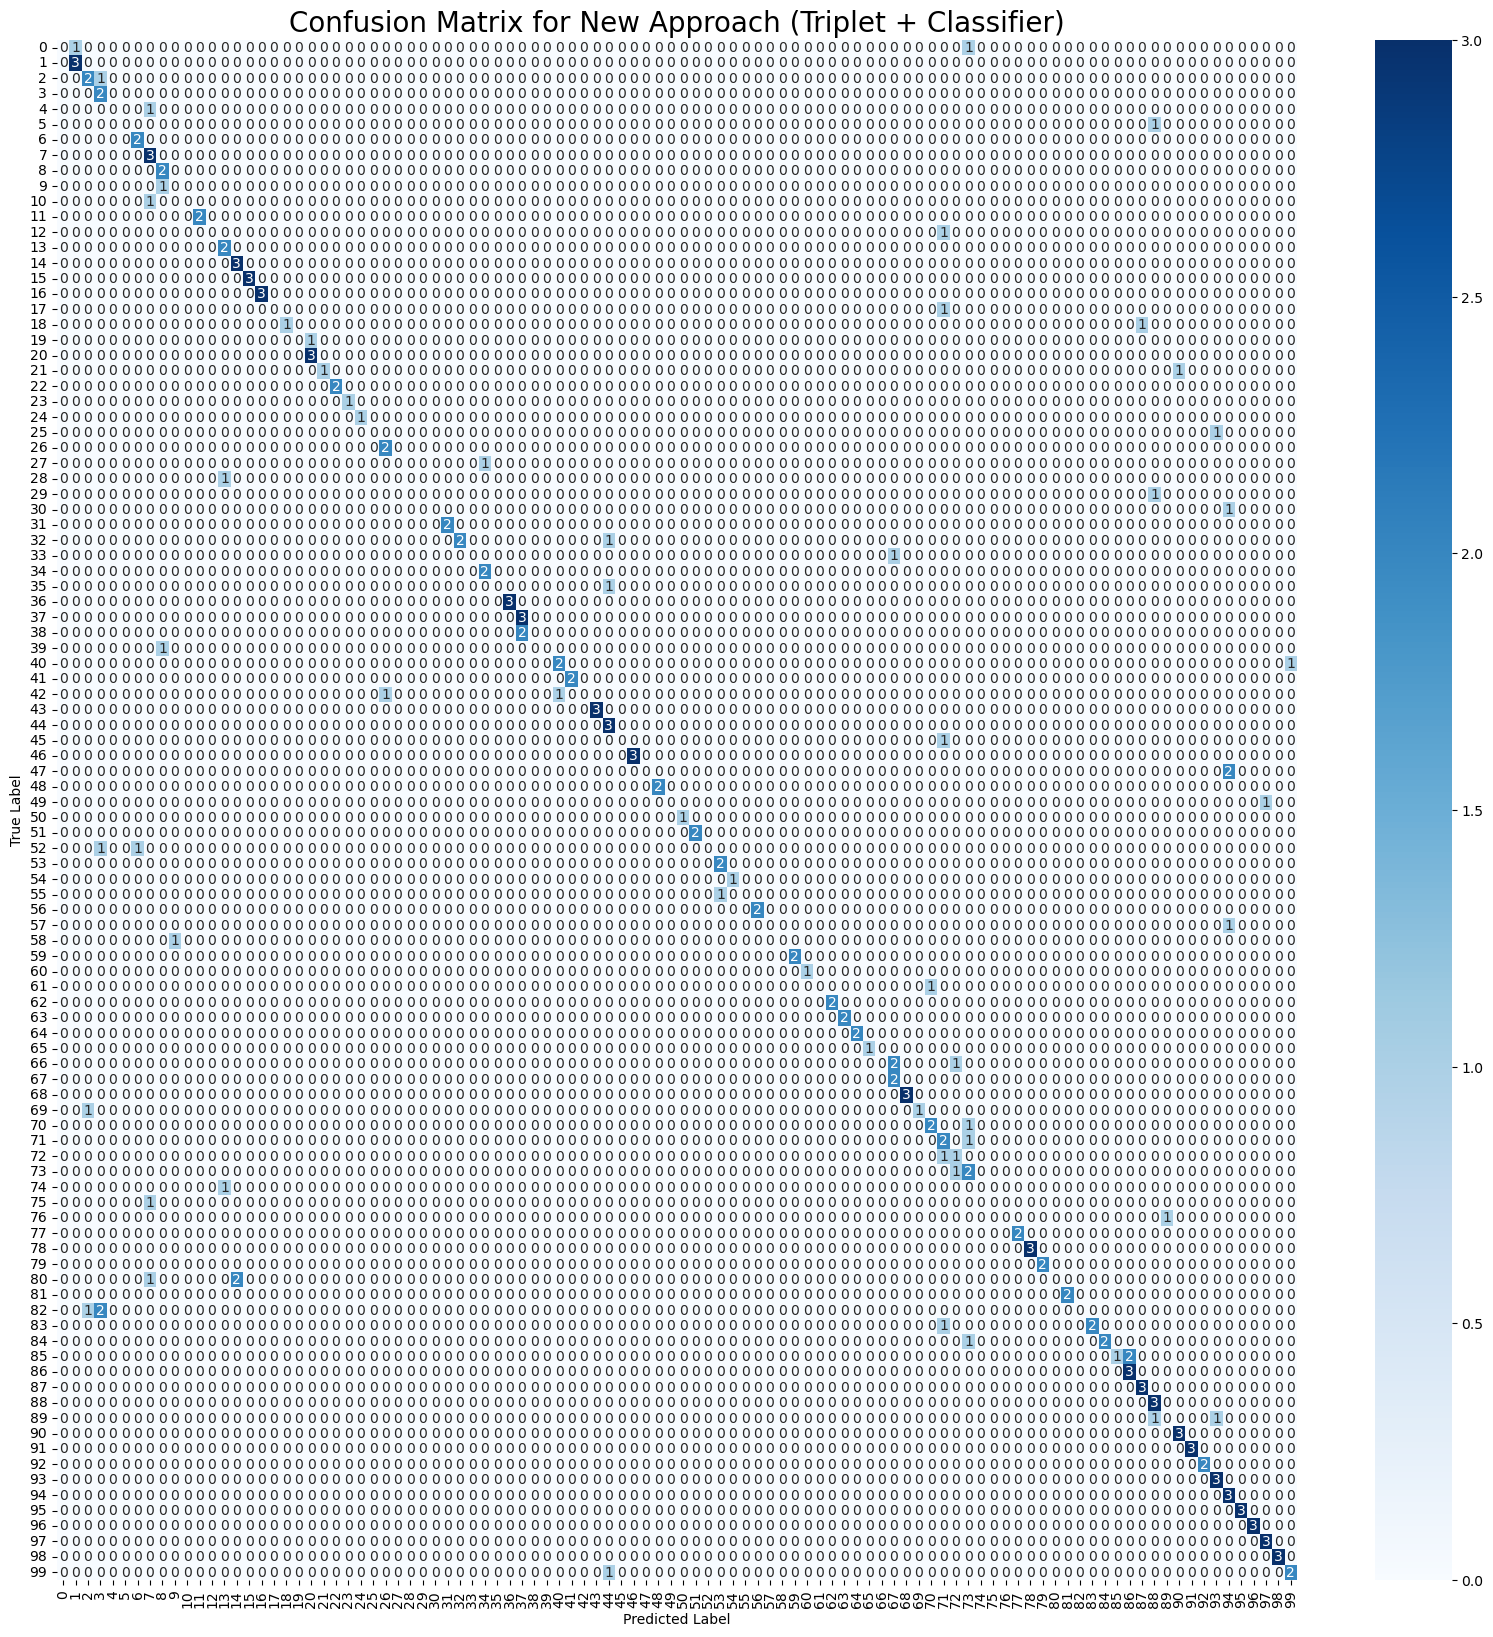


--- Analysis of Performance by Class Type ---

Group: WITH PAIRS (Trained on Herbarium + Field)
  Top-1 Accuracy: 89.54%
  Top-5 Accuracy: 98.69%

Group: WITHOUT PAIRS (Trained on Herbarium ONLY)
  Top-1 Accuracy: 18.52%
  Top-5 Accuracy: 38.89%


/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1998: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y_true, input_name="y_true")


In [16]:
# --- Plot Confusion Matrix ---
print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_top1)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=all_class_labels, yticklabels=all_class_labels)
plt.title('Confusion Matrix for New Approach (Triplet + Classifier)', fontsize=20)
plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.show()

# --- Analysis by Class Type ---
print("\n--- Analysis of Performance by Class Type ---")
with_pairs_ids = set(pd.read_csv(WITH_PAIRS_FILE, header=None).iloc[:, 0])
without_pairs_ids = set(pd.read_csv(WITHOUT_PAIRS_FILE, header=None).iloc[:, 0])
with_pairs_set = {label_map.get(id, -1) for id in with_pairs_ids}
without_pairs_set = {label_map.get(id, -1) for id in without_pairs_ids}

test_with_pairs_indices = [i for i, label in enumerate(y_test) if label in with_pairs_set]
test_without_pairs_indices = [i for i, label in enumerate(y_test) if label in without_pairs_set]

y_test_with_pairs = y_test[test_with_pairs_indices]
y_pred_top1_with_pairs = y_pred_top1[test_with_pairs_indices]
y_probas_with_pairs = y_pred_probas.numpy()[test_with_pairs_indices]
y_test_without_pairs = y_test[test_without_pairs_indices]
y_pred_top1_without_pairs = y_pred_top1[test_without_pairs_indices]
y_probas_without_pairs = y_pred_probas.numpy()[test_without_pairs_indices]

acc_top1_with = accuracy_score(y_test_with_pairs, y_pred_top1_with_pairs)
acc_top5_with = top_k_accuracy_score(y_test_with_pairs, y_probas_with_pairs, k=5, labels=all_class_labels)
acc_top1_without = accuracy_score(y_test_without_pairs, y_pred_top1_without_pairs)
acc_top5_without = top_k_accuracy_score(y_test_without_pairs, y_probas_without_pairs, k=5, labels=all_class_labels)

print(f"\nGroup: WITH PAIRS (Trained on Herbarium + Field)")
print(f"  Top-1 Accuracy: {acc_top1_with * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_with * 100:.2f}%")
print(f"\nGroup: WITHOUT PAIRS (Trained on Herbarium ONLY)")
print(f"  Top-1 Accuracy: {acc_top1_without * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_without * 100:.2f}%")